## Introduction

In this notebook, we are going to fine-tune the LayoutLM model by Microsoft Research on the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, which is a collection of annotated form documents. The goal of our model is to learn the annotations of a number of labels ("question", "answer", "header" and "other") on those forms, such that it can be used to annotate unseen forms in the future.

* Original LayoutLM paper: https://arxiv.org/abs/1912.13318

* Original FUNSD paper: https://arxiv.org/abs/1905.13538


## Install libraries

Currently you have to first install the `unilm` package, and then the `transformers` package (which updates the outdated `transformers` package that is included in the `unilm` package). The reason we also install the `unilm` package is because we need its preprocessing files. I've forked it, and removed some statements which introduced some issues.

In [3]:
! rm -r unilm
! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
! cd unilm/layoutlm
! pip install unilm/layoutlm

rm: cannot remove 'unilm': No such file or directory
Cloning into 'unilm'...
remote: Enumerating objects: 4248, done.
remote: Total 4248 (delta 0), reused 0 (delta 0), pack-reused 4248
Receiving objects: 100% (4248/4248), 7.29 MiB | 23.70 MiB/s, done.
Resolving deltas: 100% (2087/2087), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./unilm/layoutlm
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 635 kB 5.2 MB/s 
     |████████████████████████████████| 195 kB 49.5 MB/s 
     |████████████████████████████████| 5.5 MB 24.2 MB/s 
     |████

In [4]:
! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip install ./transformers

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 97414, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 97414 (delta 46), reused 67 (delta 39), pack-reused 97316
Receiving objects: 100% (97414/97414), 90.08 MiB | 22.07 MiB/s, done.
Resolving deltas: 100% (71650/71650), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./transformers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements t

## Getting the data

Here we download the data of the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/) from the web. This results in a directory called "data" being created, which has 2 subdirectories, one for training and one for testing. Each of those has 2 subdirectories in turn, one containing the images as png files and one containing the annotations in json format.

Let's take a look at a training example. For this, we are going to use PIL (Python Image Library).

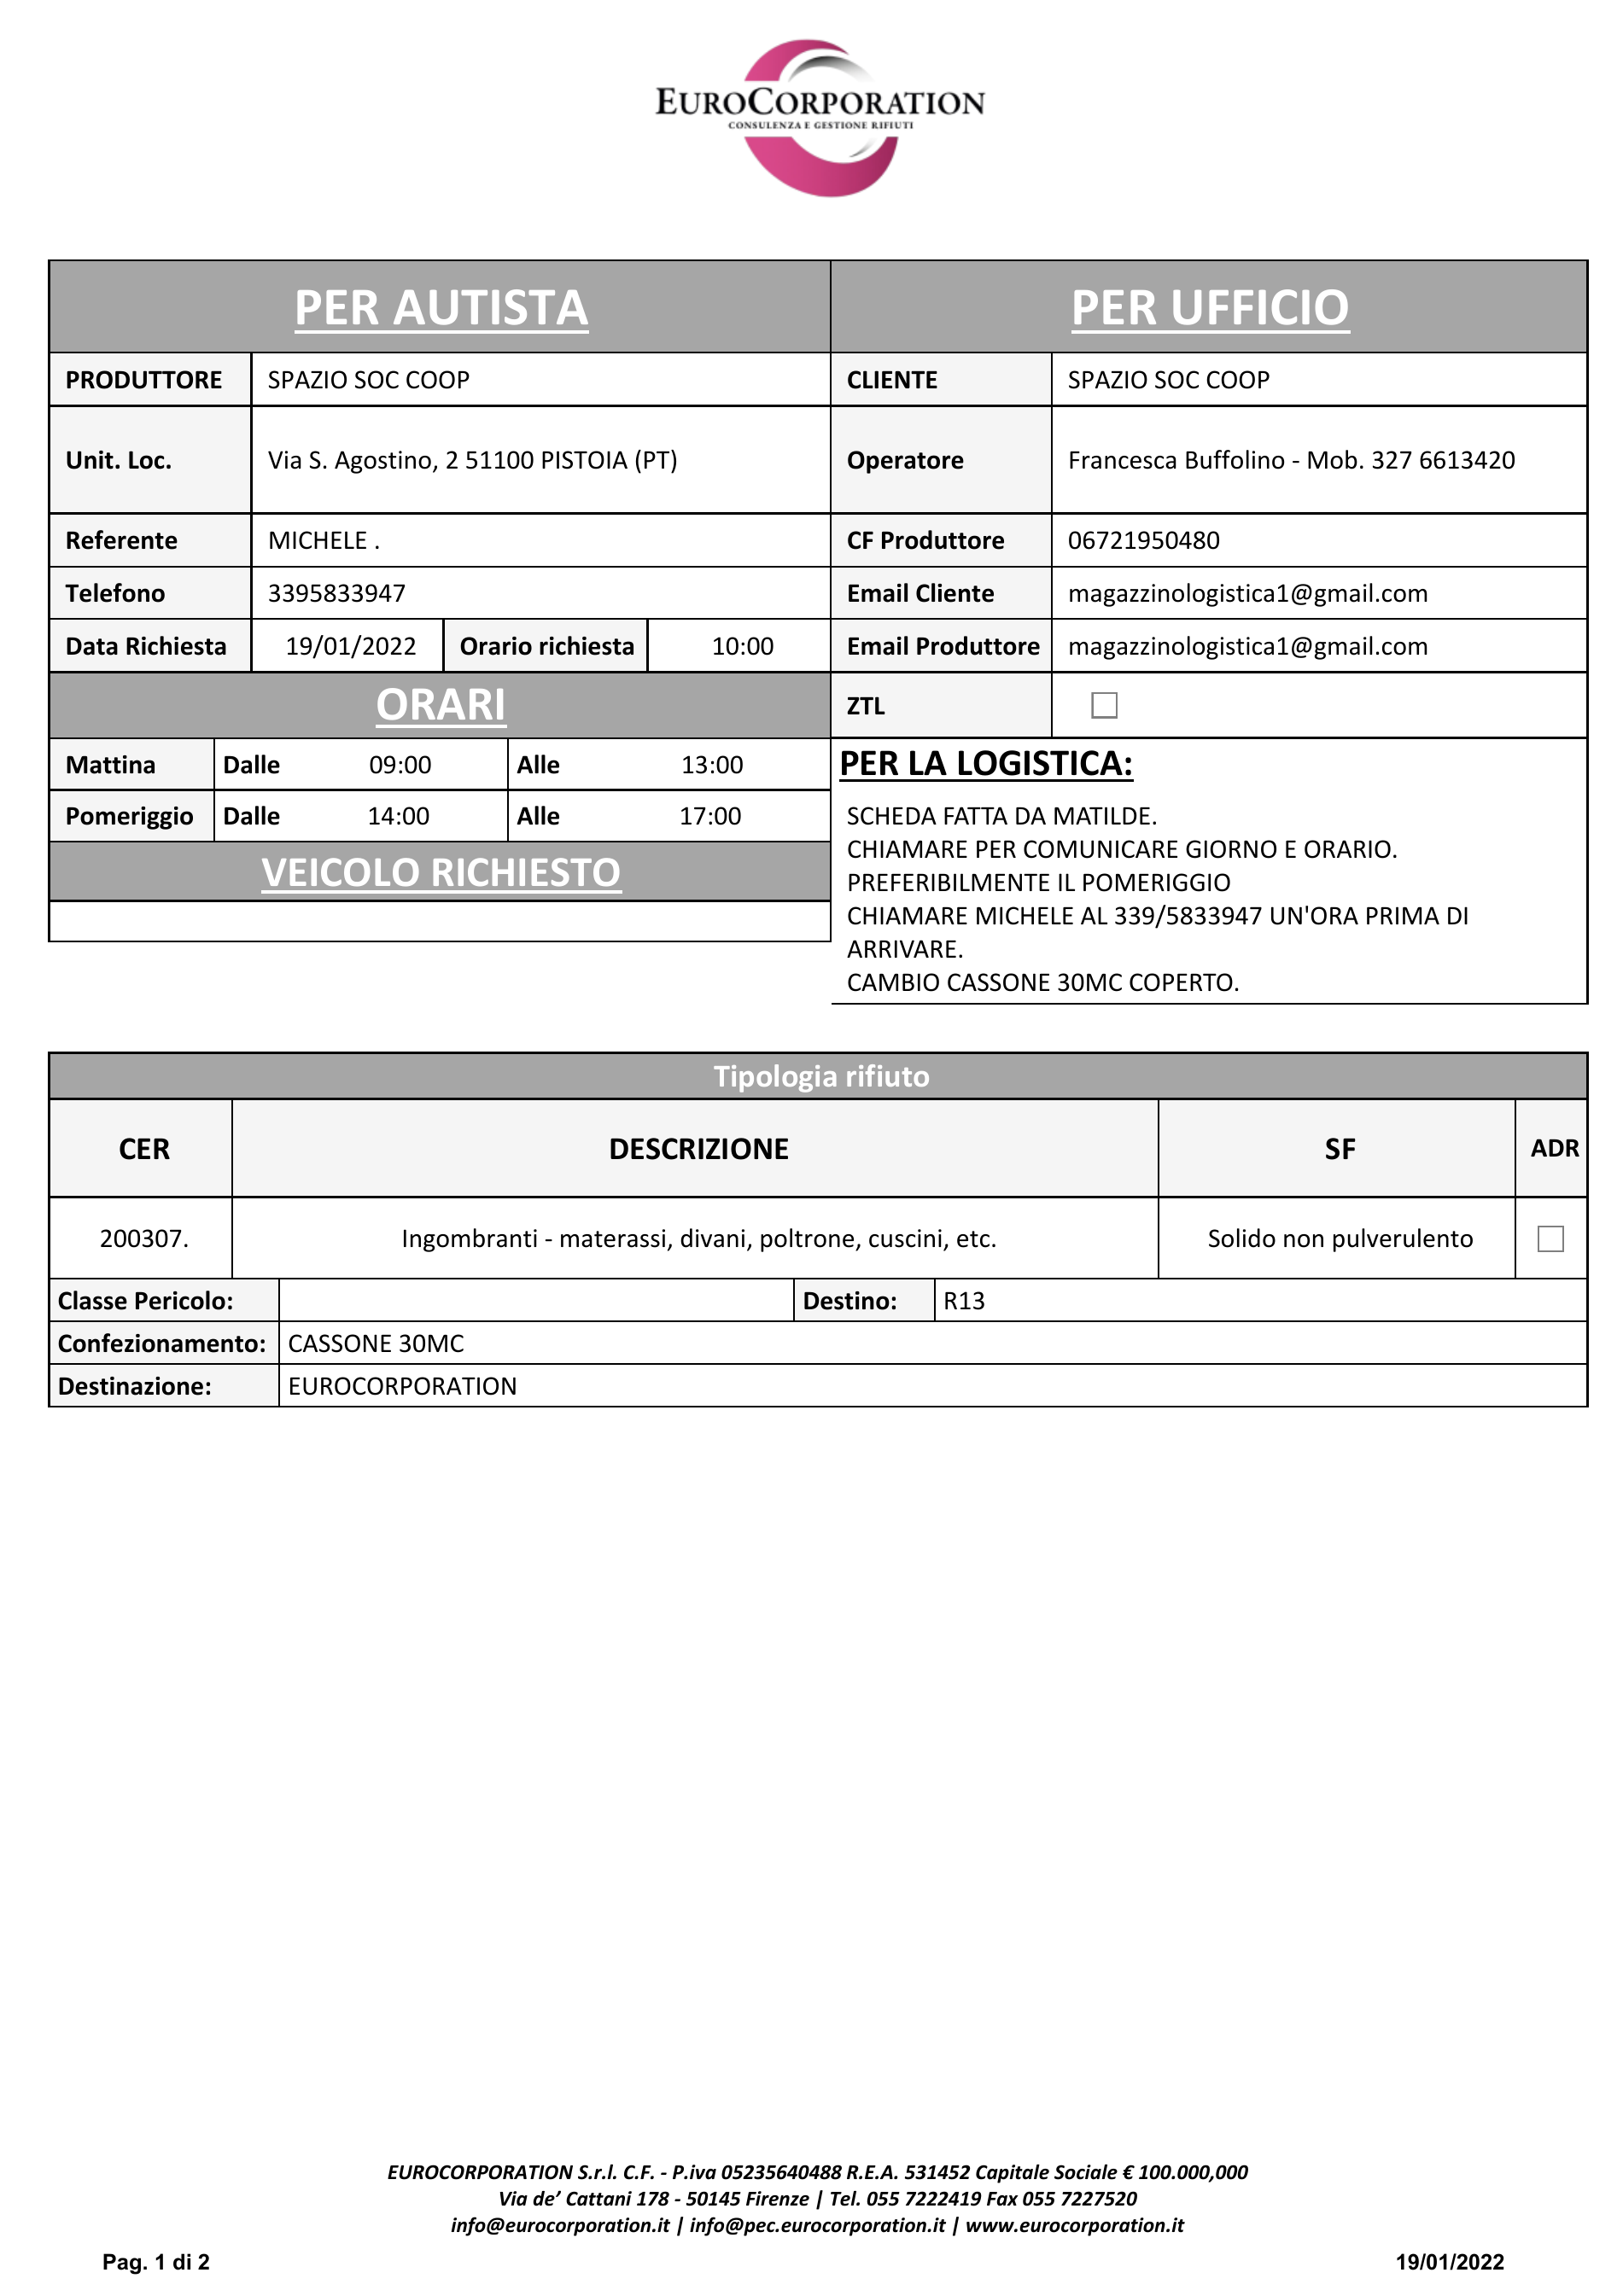

In [83]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/data/training_data/images/1.png")
image = image.convert("RGB")
image

Now let's plot its corresponding annotations. Basically, if you type `data['form']`, you get a list of all general annotations. Each general annotation has a label, a bounding box, and one or more words, which in also have their own bounding box. The bounding boxes are in [xleft, ytop, xright, ybottom] format.
 

In [84]:
import json

with open('/content/data/training_data/annotationa/1.json') as f:
  data = json.load(f)

for annotation in data['form']:
  print(annotation)

{'box': [79, 434, 258, 454], 'text': 'PRODUTTORE', 'label': 'PRODUTTORE', 'words': [{'box': [79, 434, 258, 454], 'text': 'PRODUTTORE'}], 'linking': [[0, 1, 'PER_AUTISTA']], 'id': 0}
{'box': [315, 434, 548, 454], 'text': 'SPAZIO SOC COOP', 'label': 'PRODUTTORE_ID', 'words': [{'box': [315, 434, 405, 454], 'text': 'SPAZIO'}, {'box': [416, 434, 466, 454], 'text': 'SOC'}, {'box': [476, 434, 548, 454], 'text': 'COOP'}], 'linking': [[0, 1, 'PER_AUTISTA']], 'id': 1}
{'box': [79, 527, 199, 550], 'text': 'Unit. Loc.', 'label': 'UNIT.LOC', 'words': [{'box': [79, 527, 140, 549], 'text': 'Unit.'}, {'box': [151, 528, 199, 550], 'text': 'Loc.'}], 'linking': [[2, 3, 'PER_AUTISTA']], 'id': 2}
{'box': [314, 523, 791, 556], 'text': 'Via S. Agostino, 2 51100 PISTOIA (PT)', 'label': 'UNIT.LOC_ID', 'words': [{'box': [314, 528, 351, 548], 'text': 'Via'}, {'box': [360, 523, 397, 556], 'text': 'S.'}, {'box': [392, 528, 511, 554], 'text': 'Agostino,'}, {'box': [523, 528, 535, 548], 'text': '2'}, {'box': [546, 5

The PIL library has a handy ImageDraw module, which -you guessed it- allows to draw things (such as rectangles) on an image:

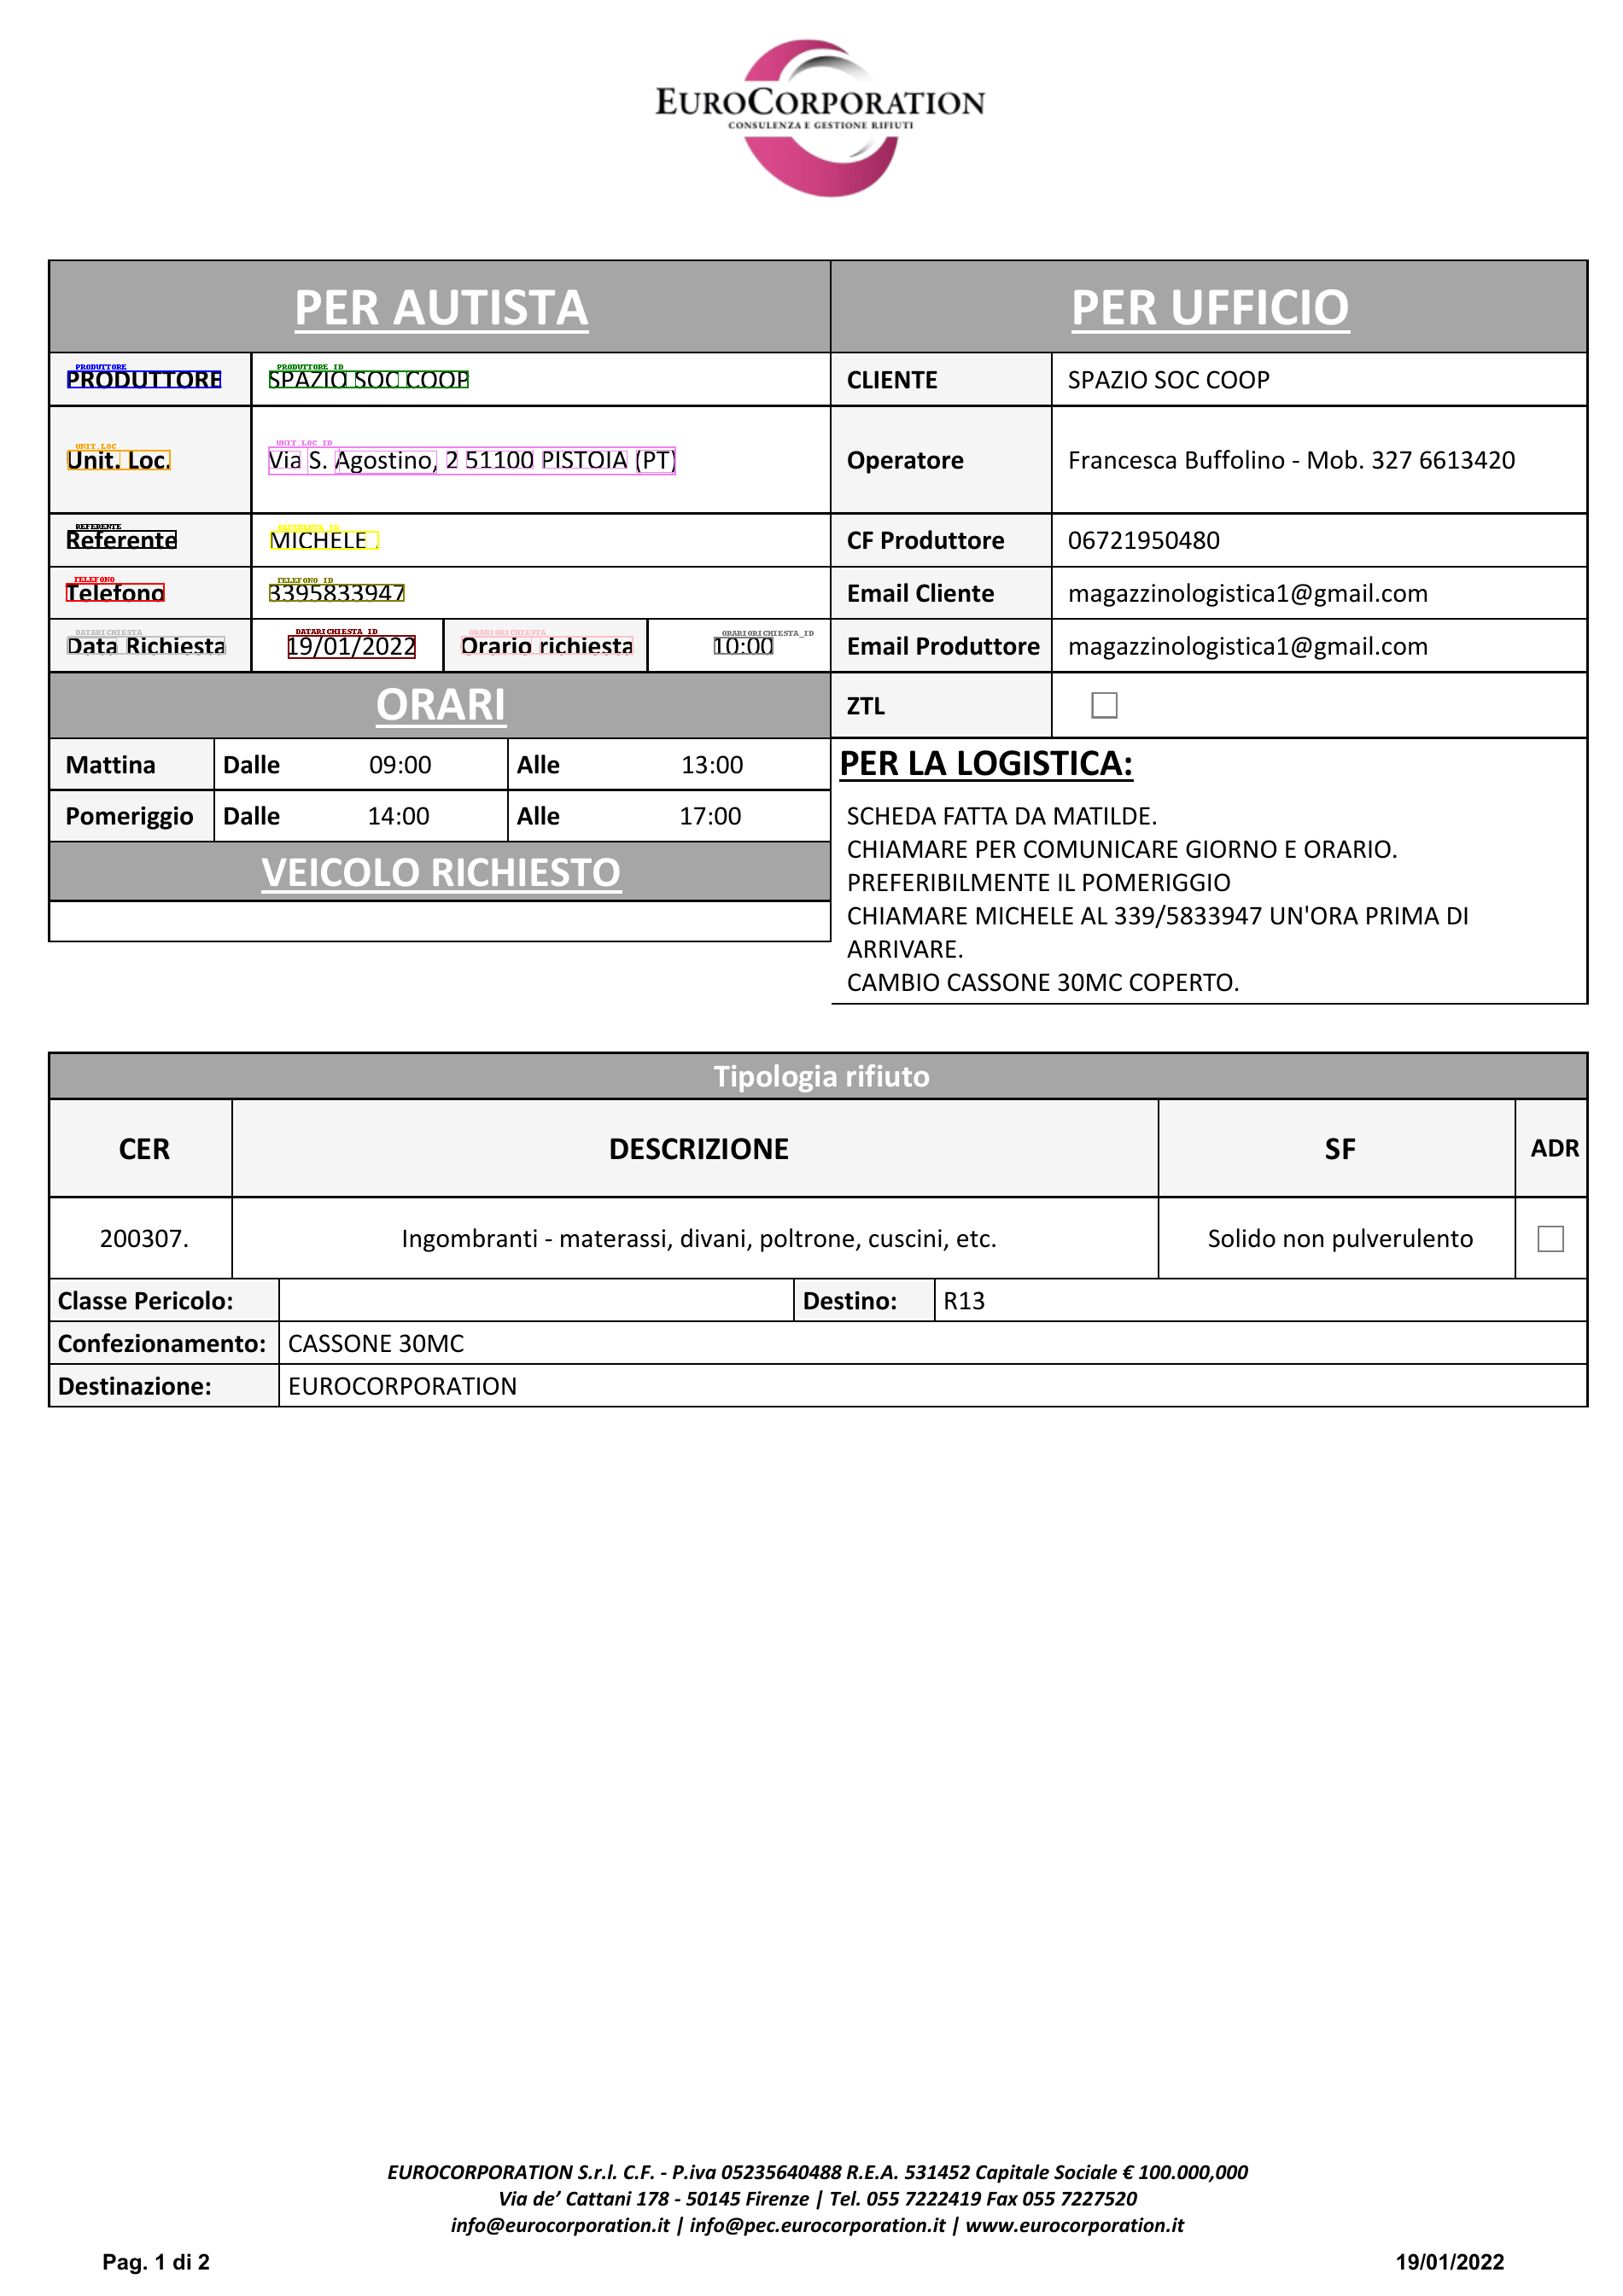

In [85]:
draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {'PRODUTTORE':'blue', 'PRODUTTORE_ID':'green', 'UNIT.LOC':'orange', 'UNIT.LOC_ID':'violet','REFERENTE':'black','REFERENTE_ID':'yellow','TELEFONO':'red','TELEFONO_ID':'olive','DATARICHIESTA':'silver','DATARICHIESTA_ID':'maroon','ORARIORICHIESTA':'pink','ORARIORICHIESTA_ID':'grey'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)

image

## Preprocessing the data

Next, we need to turn the document images into individual tokens and corresponding labels (BIOES format, see further). We do this both for the training and test datasets. Make sure to run this from the `/content` directory:

In [86]:
# ! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir data/training_data/annotations \
#                                                       --data_split train \
#                                                       --output_dir data \
#                                                       --model_name_or_path microsoft/layoutlm-base-uncased \
#                                                       --max_len 510

# ! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir data/testing_data/annotations \
#                                                       --data_split test \
#                                                       --output_dir data \
#                                                       --model_name_or_path microsoft/layoutlm-base-uncased \
#                                                       --max_len 510

Next, we create a labels.txt file that contains the unique labels of the FUNSD dataset:

In [87]:
# ! cat data/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > data/labels.txt

## Define a PyTorch dataset

First, we create a list containing the unique labels based on `data/labels.txt` (run this from the content directory):

In [88]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("data/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

We can see that the dataset uses the so-called BIOES annotation scheme to annotate the tokens. This means that a given token can be either at the beginning (B), inside (I), outside (O), at the end (E) or start (S) of a given entity. Entities include ANSWER, QUESTION, HEADER and OTHER: 

In [89]:
print(labels)

['O', 'B-DATARICHIESTA', 'B-ORARIORICHIESTA', 'B-PRODUTTORE_ID', 'B-REFERENTE_ID', 'B-TELEFONO', 'B-UNIT.LOC', 'B-UNIT.LOC_ID', 'E-DATARICHIESTA', 'E-ORARIORICHIESTA', 'E-PRODUTTORE_ID', 'E-REFERENTE_ID', 'E-TELEFONO', 'E-UNIT.LOC', 'E-UNIT.LOC_ID', 'I-PRODUTTORE_ID', 'I-UNIT.LOC_ID', 'S-DATARICHIESTA_ID', 'S-ORARIORICHIESTA_ID', 'S-PRODUTTORE', 'S-REFERENTE', 'S-TELEFONO', 'S-TELEFONO_ID']


Next, we can create a PyTorch dataset and corresponding dataloader (both for training and evaluation):

In [90]:
from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': '/content/data',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=2)

In [91]:
len(train_dataloader)

2

In [92]:
len(eval_dataloader)

1

In [93]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

'[CLS] produttore spazio soc coop unit. loc. via s. agostino, 2 51100 pistoia ( pt ) referente michele. telefono 3395833947 data richiesta 19 / 01 / 2022 orario richiesta 10 : 00 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

## Define and fine-tune the model

As this is a sequence labeling task, we are going to load `LayoutLMForTokenClassification` (the base sized model) from the hub. We are going to fine-tune it on a downstream task, namely FUNSD.

In [94]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

Now we can start training:

In [95]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 5
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  for batch in tqdm(train_dataloader, desc="Training"):
      input_ids = batch[0].to(device)
      bbox = batch[4].to(device)
      attention_mask = batch[1].to(device)
      token_type_ids = batch[2].to(device)
      labels = batch[3].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Training:   0%|          | 0/2 [00:00<?, ?it/s]

Loss after 0 steps: 3.192117929458618


Training: 100%|██████████| 2/2 [00:18<00:00,  9.39s/it]


## Evaluation

Now let's evaluate on the test set:

In [96]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

{'loss': 1.1671937704086304, 'precision': 0.7692307692307693, 'recall': 0.8333333333333334, 'f1': 0.8}


### Saving the Model

In [101]:
PATH='/content/data/'
torch.save(model.state_dict(), PATH +'layoutlm_EuroCoorp.pt')

## Inference

Now comes the fun part! We can now use the fine-tuned model and test it on unseen data.

Note that LayoutLM relies on an external OCR engine (it's not end-to-end -> that's probably something for the future). The test data itself also contains the annotated bounding boxes, but let's run an OCR engine ourselves.

So let's load in a image of the test set, run our own OCR on it to get the bounding boxes, then run LayoutLM on the individual tokens and visualize the result!

Sources:
* https://www.kaggle.com/jpmiller/layoutlm-starter
* https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0

In [102]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


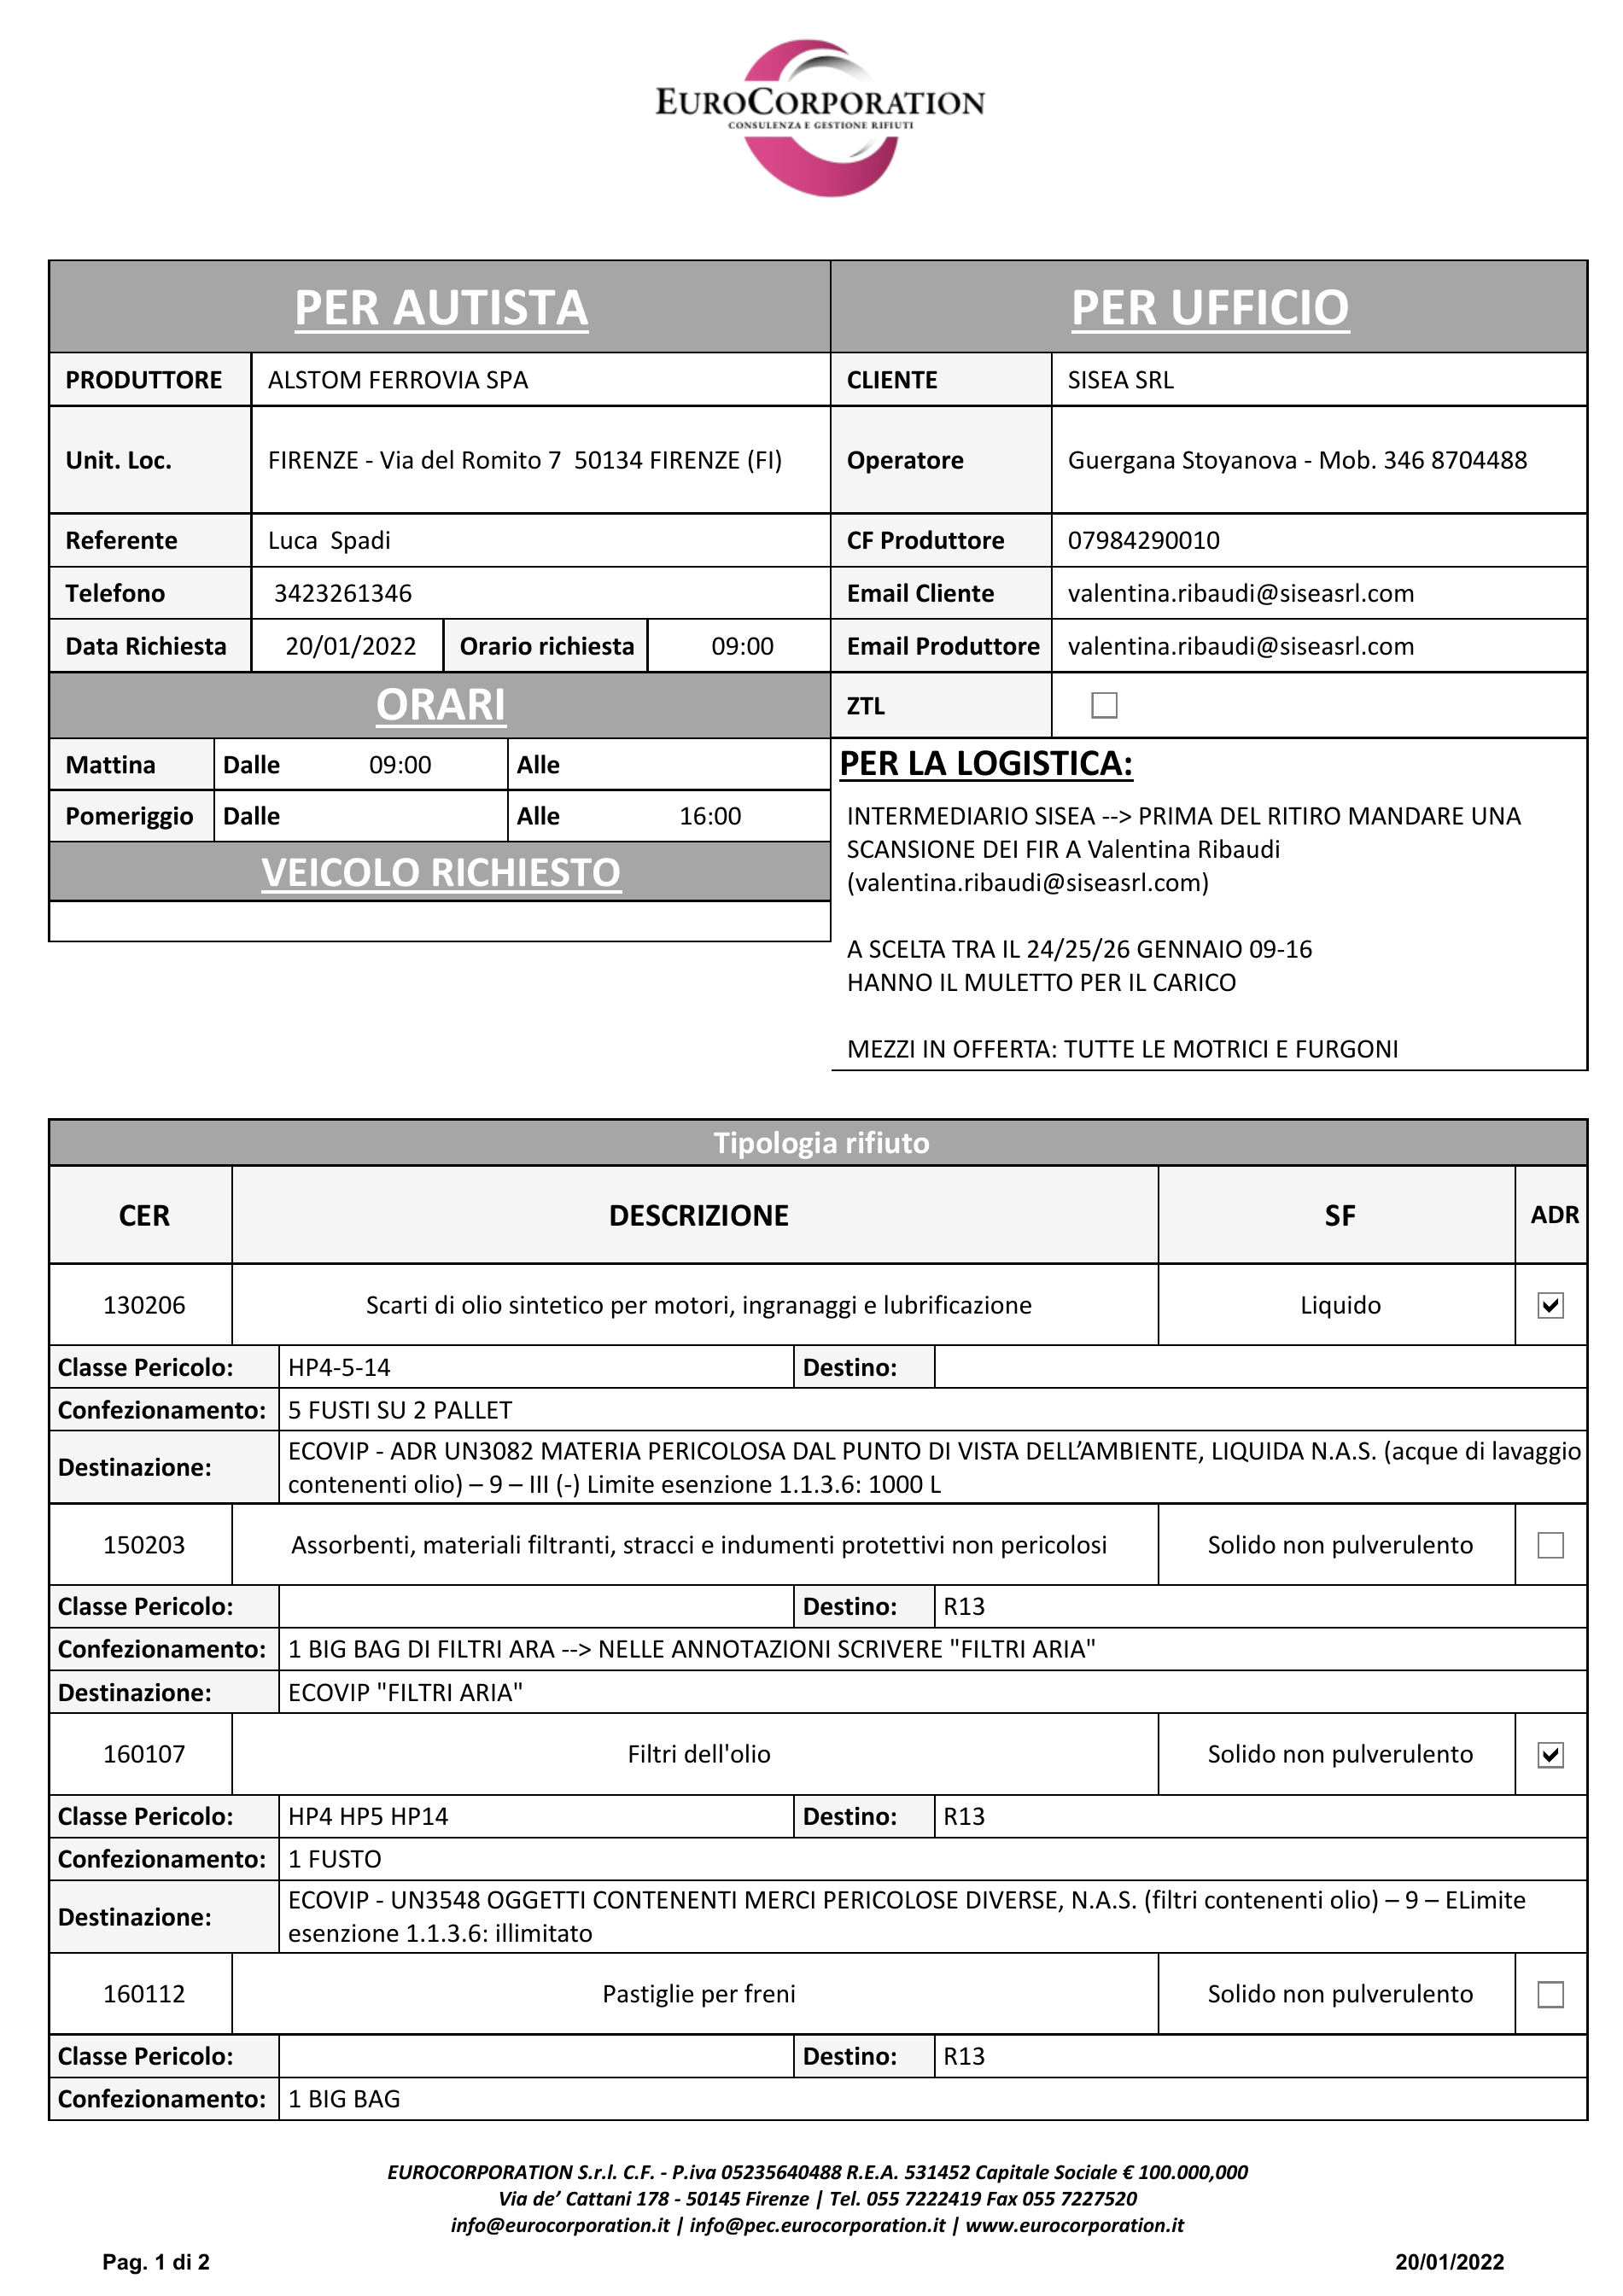

In [129]:
import pytesseract

#image = Image.open('/content/form_example.jpg')
image = Image.open("/content/data/testing_data/images/4.png")
image = image.convert("RGB")
image

Here we run Tesseract (an OCR engine built by Google) on the image:

In [130]:
import numpy as np

width, height = image.size
w_scale = 1000/width
h_scale = 1000/height

ocr_df = pytesseract.image_to_data(image, output_type='data.frame') \
            
ocr_df = ocr_df.dropna() \
               .assign(left_scaled = ocr_df.left*w_scale,
                       width_scaled = ocr_df.width*w_scale,
                       top_scaled = ocr_df.top*h_scale,
                       height_scaled = ocr_df.height*h_scale,
                       right_scaled = lambda x: x.left_scaled + x.width_scaled,
                       bottom_scaled = lambda x: x.top_scaled + x.height_scaled)

float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
ocr_df = ocr_df.dropna().reset_index(drop=True)
ocr_df[:20]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,left_scaled,width_scaled,top_scaled,height_scaled,right_scaled,bottom_scaled
0,5,1,1,1,1,1,873,47,117,48,65,a,459,62,17,18,521,35
1,5,1,2,1,1,1,769,103,384,31,90,EUROCORPORATION,405,202,38,12,607,50
2,5,1,5,1,1,1,79,434,180,21,92,PRODUTTORE,42,95,161,8,136,169
3,5,1,5,1,1,2,314,435,108,20,93,ALSTOM,165,57,162,7,222,169
4,5,1,5,1,1,3,434,435,128,20,92,FERROVIA,228,67,162,7,296,169
5,5,1,5,1,1,4,571,435,48,20,96,SPA,300,25,162,7,326,169
6,5,1,5,1,1,5,993,434,104,21,92,CLIENTE,522,55,161,8,577,169
7,5,1,5,1,1,6,1252,435,70,20,91,SISEA,659,37,162,7,695,169
8,5,1,5,1,1,7,1331,435,44,20,96,SRL,700,23,162,7,723,169
9,5,1,6,1,1,1,79,528,61,21,96,Unit.,42,32,196,8,74,204


In [153]:
ocr_df1=ocr_df.loc[ocr_df['text'].isin(['PRODUTTORE', 'ALSTOM', 'FERROVIA','SPA','Unit.','Loc.','FIRENZE','-','Via','del','Romito','7','50134','FIRENZE','(FI)','Referente','Luca','Spadi','Telefono','3423261346','Data Richiesta','20/01/2022','Orario richiesta','09:00'])]

In [154]:
ocr_df=ocr_df1

In [131]:
len(ocr_df)

260

Here we create a list of words, actual bounding boxes, and normalized boxes.

In [155]:
words = list(ocr_df.text)
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
  x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
  actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 
  actual_boxes.append(actual_box)

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

boxes = []
for box in actual_boxes:
  boxes.append(normalize_box(box, width, height))
boxes

[[41, 161, 136, 169],
 [165, 161, 221, 169],
 [228, 161, 295, 169],
 [300, 161, 325, 169],
 [41, 196, 73, 204],
 [79, 196, 105, 204],
 [166, 196, 212, 204],
 [214, 196, 229, 204],
 [234, 196, 254, 204],
 [259, 195, 278, 204],
 [285, 196, 332, 204],
 [338, 196, 345, 204],
 [354, 196, 395, 204],
 [401, 196, 447, 204],
 [803, 200, 807, 201],
 [41, 230, 108, 239],
 [166, 231, 194, 239],
 [204, 230, 239, 241],
 [40, 253, 101, 262],
 [169, 254, 253, 262],
 [176, 276, 256, 286],
 [231, 632, 236, 633],
 [231, 827, 236, 828],
 [407, 946, 410, 947],
 [308, 954, 324, 960],
 [416, 957, 419, 958],
 [860, 981, 926, 988]]

This should become the future API of LayoutLMTokenizer (`prepare_for_model()`): 

In [157]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size

      tokens = []
      token_boxes = []
      actual_bboxes = [] # we use an extra b because actual_boxes is already used
      token_actual_boxes = []
      for word, box, actual_bbox in zip(words, boxes, actual_boxes):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))

      # Truncation: account for [CLS] and [SEP] with "- 2". 
      special_tokens_count = 2 
      if len(tokens) > args.max_seq_length - special_tokens_count:
          tokens = tokens[: (args.max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]
      
      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = args.max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == args.max_seq_length
      assert len(input_mask) == args.max_seq_length
      assert len(segment_ids) == args.max_seq_length
      #assert len(label_ids) == args.max_seq_length
      assert len(token_boxes) == args.max_seq_length
      assert len(token_actual_boxes) == args.max_seq_length
      
      return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes

In [158]:
input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer, args=args)

In [159]:
tokenizer.decode(input_ids)

'[CLS] produttore alstom ferrovia spa unit. loc. firenze - via del romito 7 50134 firenze - referente luca spadi telefono 3423261346 20 / 01 / 2022 - - - via - 20 / 01 / 2022 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

Now let's perform a forward pass!

In [160]:
input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
input_ids.shape

torch.Size([1, 512])

In [161]:
attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
attention_mask.shape

torch.Size([1, 512])

In [162]:
token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
token_type_ids.shape

torch.Size([1, 512])

In [163]:
bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)
bbox.shape

torch.Size([1, 512, 4])

In [164]:
outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
outputs

TokenClassifierOutput([('logits',
                        tensor([[[-0.3353, -0.0732, -0.2722,  ...,  0.2897,  0.1421,  0.0750],
                                 [-0.0738, -0.0768, -0.1554,  ..., -0.3744, -0.4368, -0.1565],
                                 [-0.3233, -0.2297, -0.1237,  ...,  0.5160, -0.2762, -0.3785],
                                 ...,
                                 [-0.2900, -0.1559,  0.6073,  ...,  0.2487, -0.4477,  0.2419],
                                 [-0.6068, -0.0707,  0.4568,  ...,  0.3702, -0.4631,  0.1072],
                                 [-0.5997, -0.0438,  0.3770,  ...,  0.2454, -0.4204,  0.2243]]],
                               grad_fn=<AddBackward0>))])

In [165]:
outputs.logits.shape

torch.Size([1, 512, 23])

In [166]:
outputs.logits.argmax(-1)

tensor([[11, 19, 16, 16, 16,  3, 16, 15, 16, 16, 10,  6, 16, 13, 16, 11, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 20, 16, 16, 16, 16,
         21, 16, 16, 22, 22, 16, 16, 16, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 17, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 11, 11, 11, 11, 11, 11,
         11, 16, 11, 11, 11, 11, 11, 11, 11, 11, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16,

Of course, LayoutLM outputs labels at the token level, but we are interested in the predicted labels at the word level. So we should actually only incorporate the predicted labels of tokens that are the first token of a given word: 

In [167]:
token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level

word_level_predictions = [] # let's turn them into word level predictions
final_boxes = []
for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
  if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                           tokenizer.sep_token_id, 
                                                          tokenizer.pad_token_id]):
    # skip prediction + bounding box

    continue
  else:
    word_level_predictions.append(token_pred)
    final_boxes.append(box)

print(word_level_predictions)

[19, 3, 15, 10, 6, 16, 13, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 20, 16, 16, 21, 22, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 16, 16, 16, 16]


In [168]:
for id, prediction in zip(input_ids.squeeze().tolist(), word_level_predictions):
  if id != 0:
    print(tokenizer.decode([id]), label_map[prediction])

[CLS] S-PRODUTTORE
pro B-PRODUTTORE_ID
##du I-PRODUTTORE_ID
##tto E-PRODUTTORE_ID
##re B-UNIT.LOC
als I-UNIT.LOC_ID
##tom E-UNIT.LOC
fe E-REFERENTE_ID
##rro I-UNIT.LOC_ID
##via I-UNIT.LOC_ID
spa I-UNIT.LOC_ID
unit I-UNIT.LOC_ID
. I-UNIT.LOC_ID
lo I-UNIT.LOC_ID
##c I-UNIT.LOC_ID
. I-UNIT.LOC_ID
fire I-UNIT.LOC_ID
##nz S-REFERENTE
##e I-UNIT.LOC_ID
- I-UNIT.LOC_ID
via S-TELEFONO
del S-TELEFONO_ID
rom S-DATARICHIESTA_ID
##ito I-UNIT.LOC_ID
7 I-UNIT.LOC_ID
501 I-UNIT.LOC_ID
##34 I-UNIT.LOC_ID
fire I-UNIT.LOC_ID
##nz I-UNIT.LOC_ID
##e I-UNIT.LOC_ID
- I-UNIT.LOC_ID
refer I-UNIT.LOC_ID
##ente S-DATARICHIESTA_ID
luca I-UNIT.LOC_ID
spa I-UNIT.LOC_ID
##di I-UNIT.LOC_ID
tel I-UNIT.LOC_ID


In [169]:
print(len(word_level_predictions))

37


In [170]:
print(len(final_boxes))

37


Let's visualize the result!

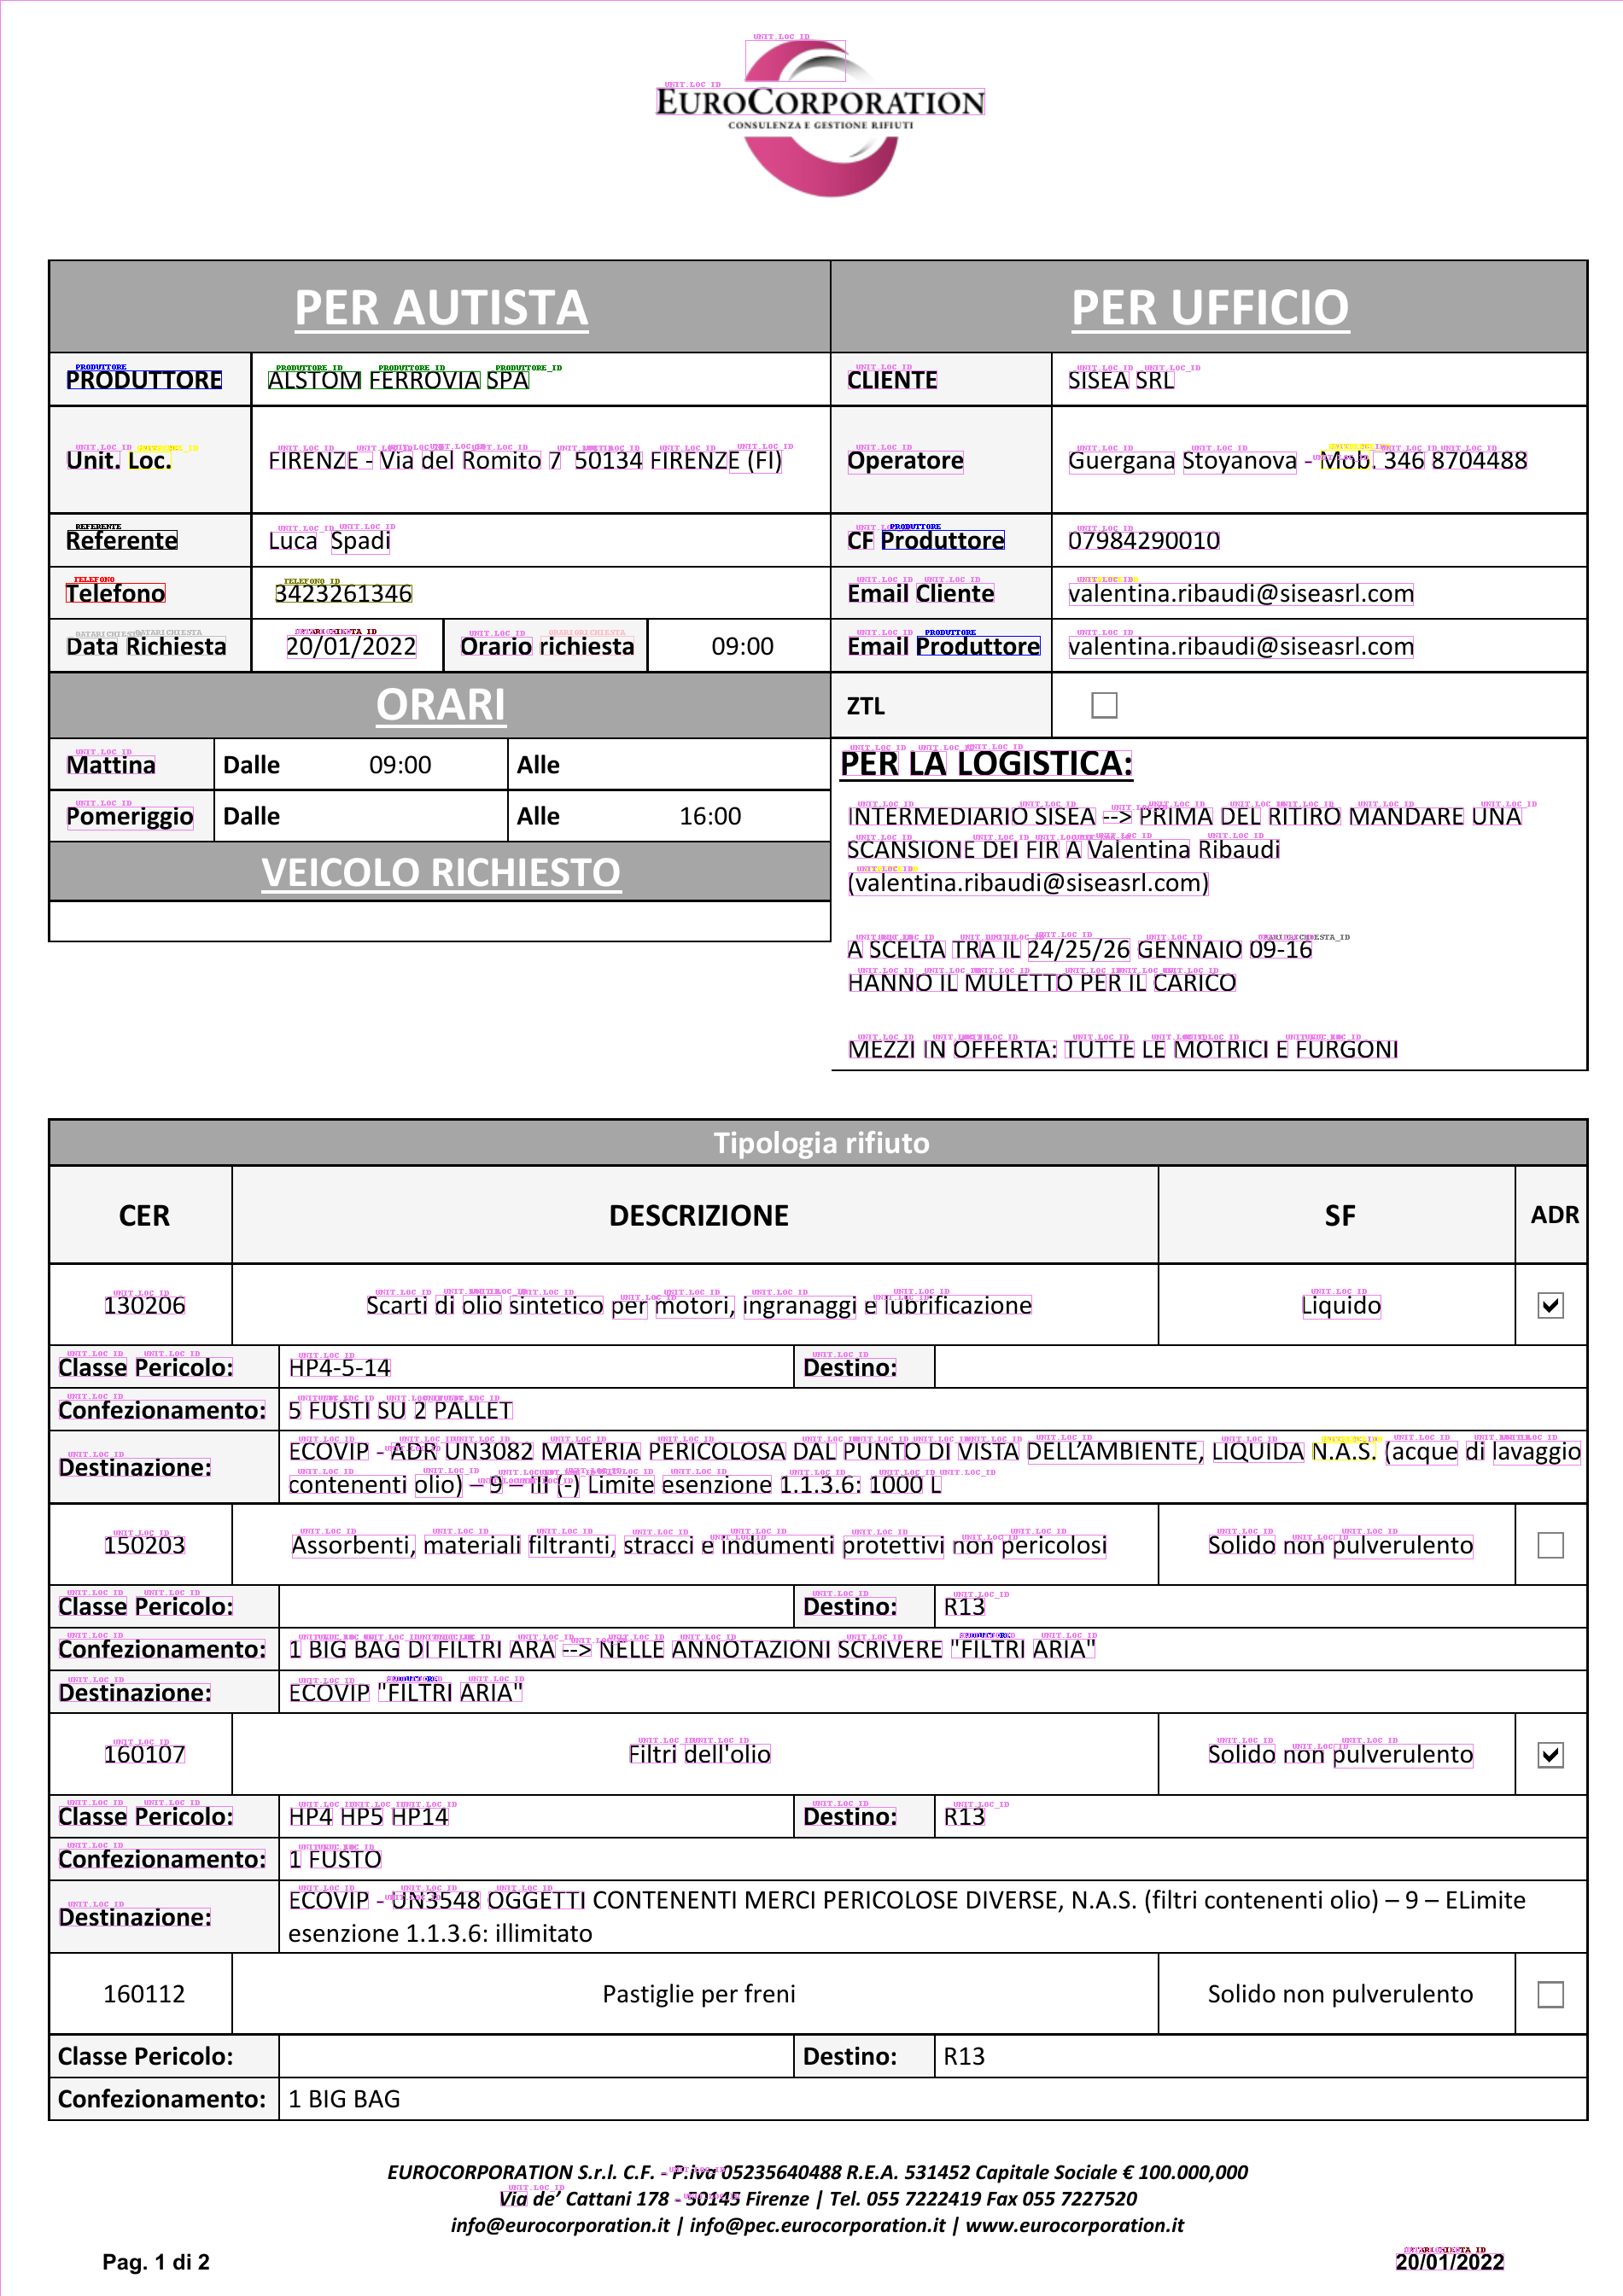

In [171]:
from PIL import Image, ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return "other"

label2color = {'PRODUTTORE':'blue', 'PRODUTTORE_ID':'green', 'UNIT.LOC':'orange', 'UNIT.LOC_ID':'violet','REFERENTE':'black','REFERENTE_ID':'yellow','TELEFONO':'red','TELEFONO_ID':'olive','DATARICHIESTA':'silver','DATARICHIESTA_ID':'maroon','ORARIORICHIESTA':'pink','ORARIORICHIESTA_ID':'grey'}
layout_details = []
for prediction, box in zip(word_level_predictions, final_boxes):
    # print(prediction)
    predicted_label = iob_to_label(label_map[prediction])
    # print(predicted_label)
    draw.rectangle(box, outline=label2color[predicted_label])
    layout_details.append((predicted_label, label_map[prediction], box, label2color[predicted_label]))
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
    # print([layout_details])

image




In [172]:
output_file='Predicted_BIOES.txt'
fout = open(output_file,'w')
for i, j in zip(words, layout_details[1:-1]):
    # print(i)
    fout.write(str(i)+" "+j[1]+ '\n')
    fout.write('\n')
fout.close()

In [173]:
"""
    convert NER/Chunking tag schemes, i.e. BIOES->BIO
"""
from __future__ import print_function
import sys

def BIOES2BIO(input_file, output_file):
    print("Convert BIOES -> BIO for file:", input_file)
    with open(input_file,'r') as in_file:
        fins = in_file.readlines()
    fout = open(output_file,'w')
    words = []
    labels = []
    for line in fins:
        if len(line) < 3:
            sent_len = len(words)
            for idx in range(sent_len):
                if "-" not in labels[idx]:
                    fout.write(words[idx]+" "+labels[idx]+"\n")
                else:
                    label_type = labels[idx].split('-')[-1]
                    if "E-" in labels[idx]:
                        fout.write(words[idx]+" I-"+label_type+"\n")
                    elif "S-" in labels[idx]:
                        fout.write(words[idx]+" B-"+label_type+"\n")
                    else:
                        fout.write(words[idx]+" "+labels[idx]+"\n")     
            fout.write('\n')
            words = []
            labels = []
        else:
            pair = line.strip('\n').split()
            words.append(pair[0])
            labels.append(pair[-1].upper())
    fout.close()
    print("BIO file generated:", output_file)



if __name__ == '__main__':
    BIOES2BIO('/content/Predicted_BIOES.txt','jyotBIO.txt')

Convert BIOES -> BIO for file: /content/Predicted_BIOES.txt
BIO file generated: jyotBIO.txt


In [178]:
!pip install nltk
import nltk
nltk.download('averaged_perceptron_tagger')


from nltk import pos_tag
from nltk.tree import Tree
from nltk.chunk import conlltags2tree

import pandas as pd
data = pd.read_csv("/content/jyotBIO.txt", sep = " ", names=['Value','key'], header=None)
data

tokens = list(data['Value'])
tags = list(data['key'])


pos_tags = [pos for token, pos in pos_tag(tokens)]
conlltags = [(token, pos, tg) for token, pos, tg in zip(tokens, pos_tags, tags)]
ne_tree = conlltags2tree(conlltags)

original_text = []
for subtree in ne_tree:
    # skipping 'O' tags
    if type(subtree) == Tree:
        original_label = subtree.label()
        original_string = " ".join([token for token, pos in subtree.leaves()])
        original_text.append((original_label,original_string))
print(original_text)

d=dict(original_text)
d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[('PRODUTTORE_ID', 'PRODUTTORE ALSTOM FERROVIA'), ('UNIT.LOC', 'SPA'), ('UNIT.LOC_ID', 'Unit.'), ('UNIT.LOC', 'Loc.'), ('REFERENTE_ID', 'FIRENZE'), ('UNIT.LOC_ID', '- Via del Romito 7 50134 FIRENZE - Referente'), ('REFERENTE', 'Luca'), ('UNIT.LOC_ID', 'Spadi Telefono'), ('TELEFONO', '3423261346'), ('TELEFONO_ID', '20/01/2022'), ('DATARICHIESTA_ID', '-'), ('UNIT.LOC_ID', '- - Via - 20/01/2022')]


{'DATARICHIESTA_ID': '-',
 'PRODUTTORE_ID': 'PRODUTTORE ALSTOM FERROVIA',
 'REFERENTE': 'Luca',
 'REFERENTE_ID': 'FIRENZE',
 'TELEFONO': '3423261346',
 'TELEFONO_ID': '20/01/2022',
 'UNIT.LOC': 'Loc.',
 'UNIT.LOC_ID': '- - Via - 20/01/2022'}

In [179]:
import json
with open('JSON.json', 'w') as fp:
    json.dump(d, fp)

Compare this to the ground truth:

In [176]:
import json
with open('/content/data/testing_data/annotationa/4.json') as f:
  data = json.load(f)

for annotation in data['form']:
  print(annotation)

{'box': [79, 434, 259, 456], 'text': 'PRODUTTORE', 'label': 'PRODUTTORE', 'words': [{'box': [79, 434, 259, 456], 'text': 'PRODUTTORE'}], 'linking': [[0, 1, 'PER_AUTISTA']], 'id': 0}
{'box': [314, 434, 618, 454], 'text': 'ALSTOM FERROVIA SPA', 'label': 'PRODUTTORE_ID', 'words': [{'box': [314, 434, 421, 454], 'text': 'ALSTOM'}, {'box': [434, 434, 561, 454], 'text': 'FERROVIA'}, {'box': [571, 434, 618, 454], 'text': 'SPA'}], 'linking': [[0, 1, 'PER_AUTISTA']], 'id': 1}
{'box': [79, 527, 199, 550], 'text': 'Unit. Loc.', 'label': 'UNIT.LOC', 'words': [{'box': [79, 527, 140, 549], 'text': 'Unit.'}, {'box': [151, 528, 199, 550], 'text': 'Loc.'}], 'linking': [[2, 3, 'PER_AUTISTA']], 'id': 2}
{'box': [316, 527, 914, 553], 'text': 'FIRENZE - Via del Romito 7 50134 FIRENZE (FI)', 'label': 'UNIT.LOC_ID', 'words': [{'box': [316, 529, 418, 548], 'text': 'FIRENZE'}, {'box': [429, 540, 435, 541], 'text': '-'}, {'box': [445, 528, 482, 548], 'text': 'Via'}, {'box': [494, 527, 530, 548], 'text': 'del'}, 

Note that we only print the labels for the general bounding boxes, for readability. Each general bounding box consists of one or more bounding boxes, which comprise the individual words:

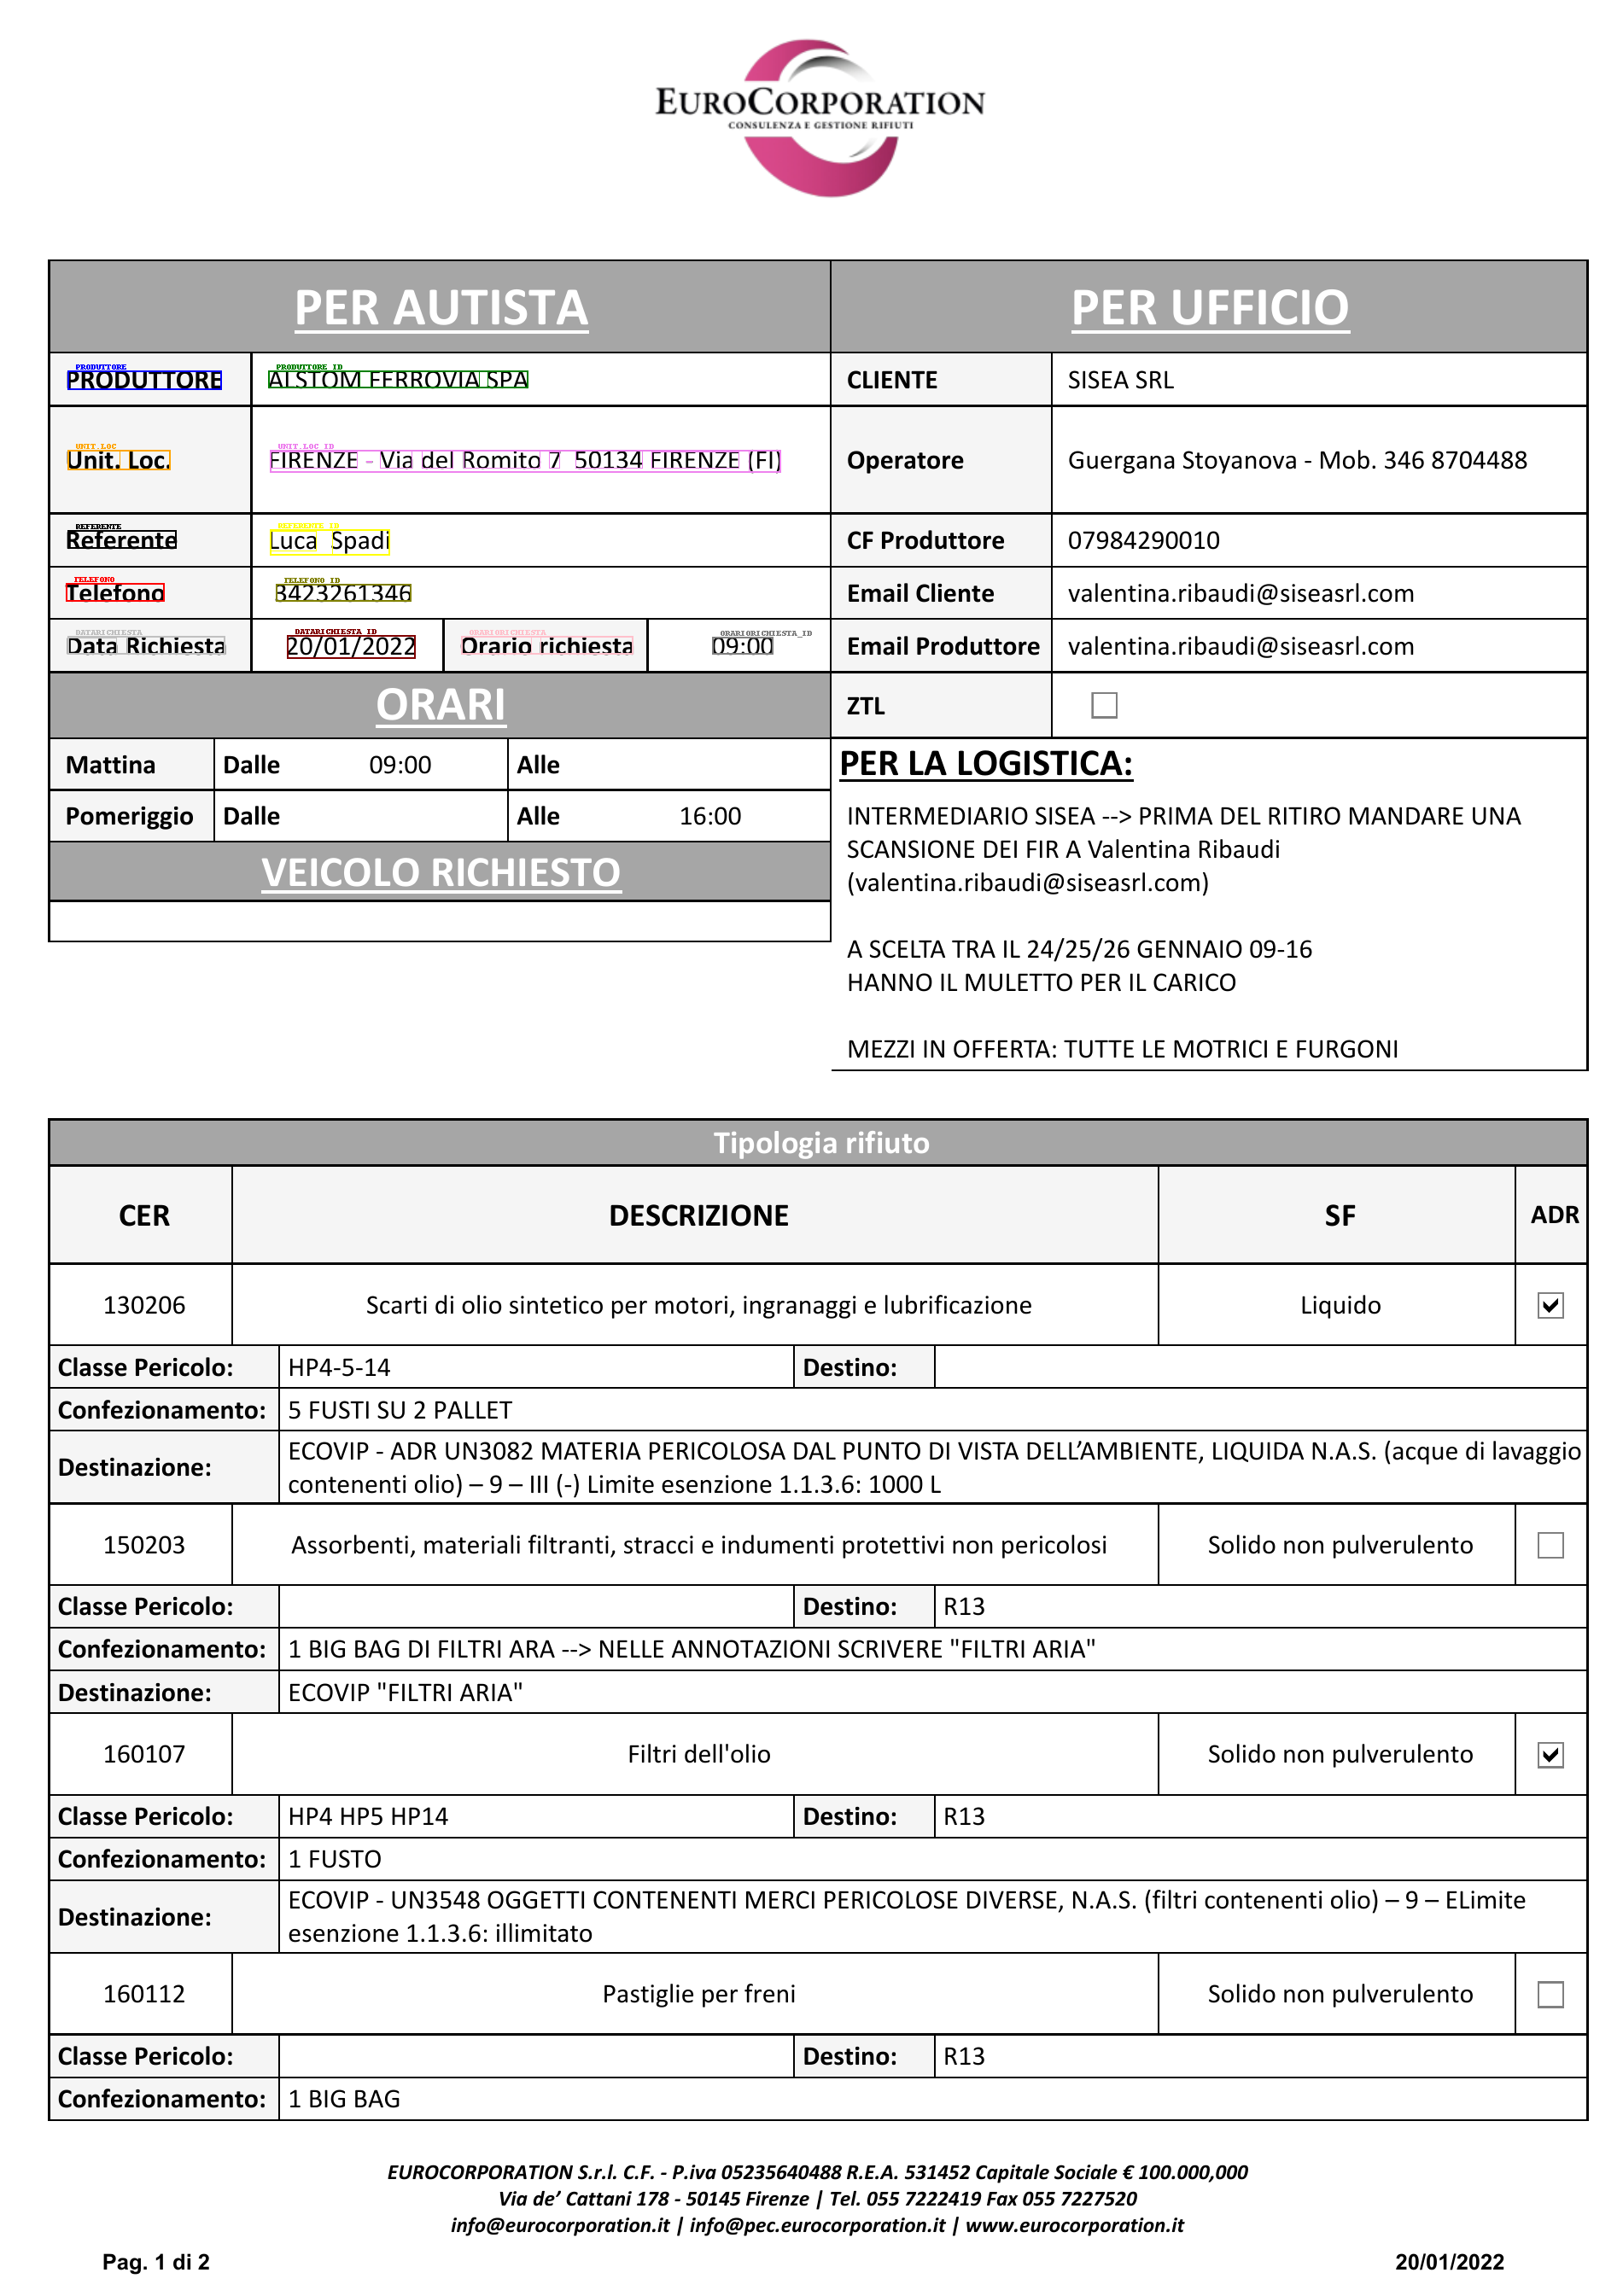

In [177]:
image = Image.open("/content/data/testing_data/images/4.png")
image = image.convert('RGB')

draw = ImageDraw.Draw(image)

label2color = {'PRODUTTORE':'blue', 'PRODUTTORE_ID':'green', 'UNIT.LOC':'orange', 'UNIT.LOC_ID':'violet','REFERENTE':'black','REFERENTE_ID':'yellow','TELEFONO':'red','TELEFONO_ID':'olive','DATARICHIESTA':'silver','DATARICHIESTA_ID':'maroon','ORARIORICHIESTA':'pink','ORARIORICHIESTA_ID':'grey'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)

image